In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pylab as plt
import back_test_bot as bb

In [3]:
df = bb.fetch_btc_history(interval="1h", start_date="2024-01-01")

In [6]:
df

,timestamp,high,low,price,volume
0,2024-01-01 00:59:59.999000+00:00,42554.57,42261.02,42475.23,1271.68108
1,2024-01-01 01:59:59.999000+00:00,42775.00,42431.65,42613.56,1196.37856
2,2024-01-01 02:59:59.999000+00:00,42638.41,42500.00,42581.10,685.21980
3,2024-01-01 03:59:59.999000+00:00,42586.64,42230.08,42330.49,794.80391
4,2024-01-01 04:59:59.999000+00:00,42399.99,42209.46,42399.99,715.41760
...,...,...,...,...,...
18252,2026-01-30 12:59:59.999000+00:00,83329.35,82650.00,82800.50,693.01620
18253,2026-01-30 13:59:59.999000+00:00,83087.34,82421.64,82740.92,760.57185
18254,2026-01-30 14:59:59.999000+00:00,83797.99,82738.68,83098.00,1785.40114
18255,2026-01-30 15:59:59.999000+00:00,83616.46,82382.01,82883.94,1512.89136


df = bb.fetch_btc_history(interval="3m", start_date="2026-01-01")

In [8]:
# Compute rolling VWAP
df["vwap"] = bb.rolling_vwap(df, window=12)

In [9]:
# Detect deviations > 3%
df = bb.detect_large_moves(df, threshold=0.01)

In [10]:
df = bb.trade_direction(df)

In [11]:
df = bb.best_bot(df)

In [12]:
df_sample = df.tail(200)

In [13]:
def plot_trade_events(df):
    fig, ax = plt.subplots(figsize=(10,8))
    df.plot(ax=ax, x='timestamp',y='price')
    df.plot(ax=ax, x='timestamp',y='deviation',secondary_y=True,alpha=0.2,ls='-.')
    df.plot(ax=ax, x='timestamp',y='vwap',color='k',ls=':')
    df[df['trade']=='Buy'].plot.scatter(ax=ax, x='timestamp',y='price', color='green',label = 'buy')
    df[df['trade']=='Sell'].plot.scatter(ax=ax, x='timestamp',y='price', color='red', label = "sell")
    ax.legend(ncols=5)

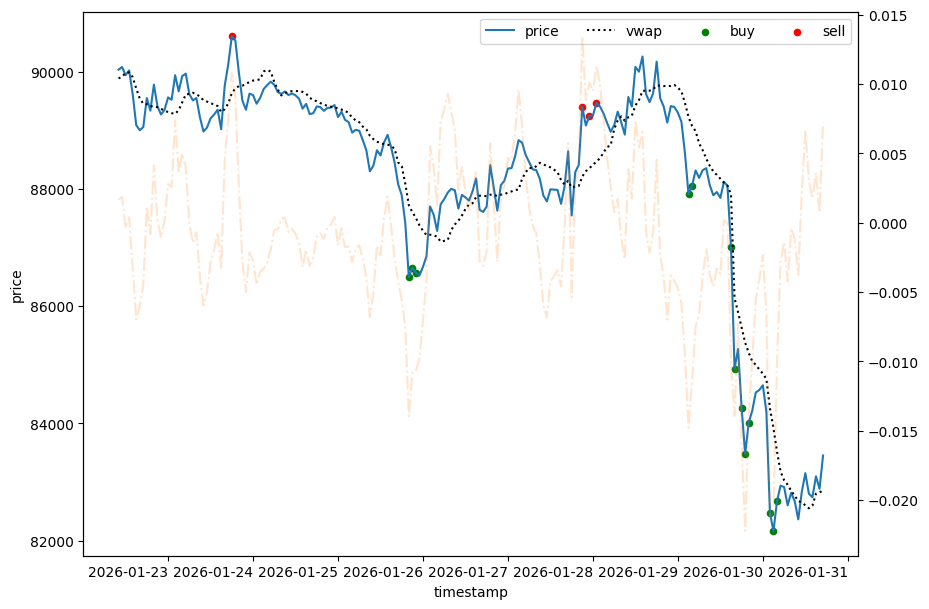

In [14]:
plot_trade_events(df_sample)

In [25]:
df

,timestamp,high,low,price,volume,vwap,deviation,signal,trade,max_profit
0,2024-01-01 00:59:59.999000+00:00,42554.57,42261.02,42475.23,1271.68108,NaN,NaN,False,Wait,293.55
1,2024-01-01 01:59:59.999000+00:00,42775.00,42431.65,42613.56,1196.37856,NaN,NaN,False,Wait,343.35
2,2024-01-01 02:59:59.999000+00:00,42638.41,42500.00,42581.10,685.21980,NaN,NaN,False,Wait,138.41
3,2024-01-01 03:59:59.999000+00:00,42586.64,42230.08,42330.49,794.80391,NaN,NaN,False,Wait,356.56
4,2024-01-01 04:59:59.999000+00:00,42399.99,42209.46,42399.99,715.41760,NaN,NaN,False,Wait,190.53
...,...,...,...,...,...,...,...,...,...,...
18252,2026-01-30 12:59:59.999000+00:00,83329.35,82650.00,82800.50,693.01620,82552.694638,0.003002,False,Wait,679.35
18253,2026-01-30 13:59:59.999000+00:00,83087.34,82421.64,82740.92,760.57185,82596.759254,0.001745,False,Wait,665.70
18254,2026-01-30 14:59:59.999000+00:00,83797.99,82738.68,83098.00,1785.40114,82801.153616,0.003585,False,Wait,1059.31
18255,2026-01-30 15:59:59.999000+00:00,83616.46,82382.01,82883.94,1512.89136,82825.275602,0.000708,False,Wait,1234.45


In [26]:
df[['price','signal']]

,price,signal
0,42475.23,False
1,42613.56,False
2,42581.10,False
3,42330.49,False
4,42399.99,False
...,...,...
18252,82800.50,False
18253,82740.92,False
18254,83098.00,False
18255,82883.94,False


In [15]:
def plot_profit(df):
    cum_max = round(df['max_profit'].sum())
    df.plot(x='timestamp',y='max_profit', ylabel = 'Profit (USD)', title = f'Cumulative max: ${cum_max}')

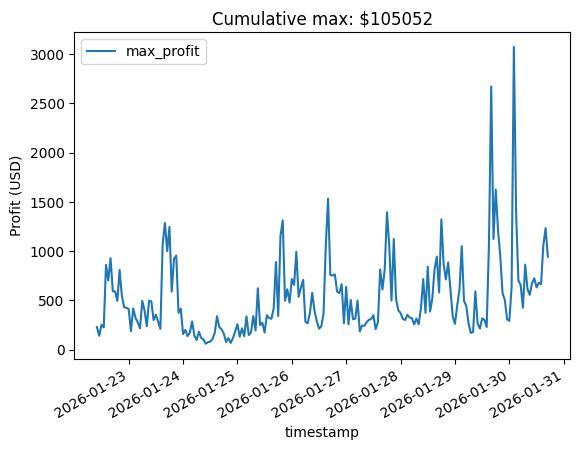

In [16]:
plot_profit(df_sample)

In [17]:
df['trade'].value_counts(normalize=True)

trade
Wait    0.836337
Sell    0.087528
Buy     0.076135
Name: proportion, dtype: float64

## Fourier transform

In [18]:
# 5. Fourier analysis
price_series = df.set_index("timestamp")["price"]
returns = bb.detrend_series(price_series, method="log_return")

In [19]:
# 14-day rolling FFT on hourly data
fft_window = 24*7
dominant_cycles = bb.dominant_cycle(
    returns,
    window=fft_window,
    sampling_interval=1.0
)

In [20]:
# Align output
cycle_df = pd.DataFrame({
    "timestamp": returns.index[fft_window:],
    "dominant_cycle_hours": dominant_cycles
})

(0.0, 5.0)

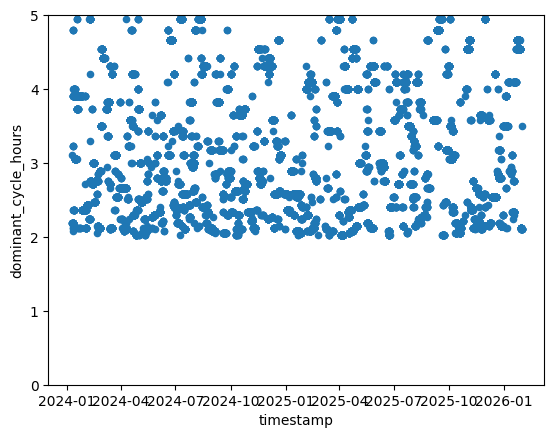

In [24]:
cycle_df.plot.scatter(x='timestamp',y='dominant_cycle_hours')
plt.ylim(0,5)

In [18]:
cycle_df.mean()

timestamp               2025-01-15 17:59:59.999000320+00:00
dominant_cycle_hours                               7.058169
dtype: object

In [19]:
cycle_df['dominant_cycle_hours'].value_counts()

dominant_cycle_hours
2.584615      475
4.097561      466
4.307692      440
8.842105      438
2.400000      424
             ... 
3.294118       71
2.947368       63
7.304348       59
10.500000      36
168.000000     27
Name: count, Length: 83, dtype: int64

In [20]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/bin/python'